# Installing Libs

In [ ]:
!pip install catboost -q
!pip install lightgbm -q
!pip install xgboost -q
!pip install opencv-python
!pip install gdown -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 55.6 MB/s eta 0:00:00


# Imports

In [ ]:
import warnings
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
from pathlib import Path
import warnings
import random

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    balanced_accuracy_score,
    auc
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
warnings.filterwarnings('ignore')

# Constant

In [ ]:
image_size = 256

# Downloading Dataset

In [ ]:
! gdown 1-7SvuJS_cl5XDWEd8z6ruPR-OEMQNSWA

Downloading...
From (original): https://drive.google.com/uc?id=1-7SvuJS_cl5XDWEd8z6ruPR-OEMQNSWA
From (redirected): https://drive.google.com/uc?id=1-7SvuJS_cl5XDWEd8z6ruPR-OEMQNSWA&confirm=t&uuid=384df905-eeef-4153-a881-9f83e6bc4dd2
To: /content/Leaf Image.zip
100% 99.6M/99.6M [00:01<00:00, 51.2MB/s]


In [ ]:
!rm -r Dataset

rm: cannot remove 'Dataset': No such file or directory


In [ ]:
!unzip -q *.zip -d Dataset/

In [ ]:
def extract_hog_features(image, image_size=(256, 256)):
    try:
        image_resized = cv2.resize(image, image_size)

        if len(image_resized.shape) == 3:
            gray_image = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
        else:
            gray_image = image_resized

        hog_feature = hog(
            gray_image,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            transform_sqrt=True,
            visualize=False,
            feature_vector=True
        )

        return hog_feature

    except Exception as e:
        print(f"Error extracting HOG features: {e}")
        return None

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from tqdm import tqdm

def process_single_image(image_info):

    image_path, class_name, image_size = image_info

    try:
        image = cv2.imread(str(image_path))
        if image is None:
            return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hog_feature = extract_hog_features(image, image_size)

        if hog_feature is not None:
            return (hog_feature, class_name, str(image_path))
        else:
            return None

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def load_images_and_extract_features(base_path, image_size=(256, 256), max_workers=None):

    base_path = Path(base_path)
    hog_features = []
    labels = []
    all_image_paths = []


    class_folders = [f for f in base_path.iterdir() if f.is_dir()]
    class_names = [f.name for f in class_folders]

    print(f"Found classes: {class_names}")
    all_image_info = []

    for class_folder in class_folders:
        class_name = class_folder.name
        print(f"Scanning class: {class_name}")

        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']

        image_files = []
        for ext in image_extensions:
            image_files.extend(list(class_folder.glob(f"*{ext}")))
            image_files.extend(list(class_folder.glob(f"*{ext.upper()}")))

        print(f"Found {len(image_files)} images in {class_name}")

        for image_path in image_files:
            all_image_info.append((image_path, class_name, image_size))

    print(f"Total images to process: {len(all_image_info)}")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        with tqdm(total=len(all_image_info), desc="Processing images") as pbar:
            future_to_info = {executor.submit(process_single_image, info): info
                             for info in all_image_info}

            for future in as_completed(future_to_info):
                result = future.result()
                if result is not None:
                    hog_feature, class_name, image_path = result
                    hog_features.append(hog_feature)
                    labels.append(class_name)
                    all_image_paths.append(image_path)

                pbar.update(1)

    hog_features = np.array(hog_features)
    labels = np.array(labels)
    all_image_paths = np.array(all_image_paths)

    print(f"Total samples loaded: {len(hog_features)}")
    print(f"Feature vector size: {hog_features.shape[1] if len(hog_features) > 0 else 0}")

    return hog_features, labels, class_names, all_image_paths


# Loading Data and Feature Extraction

In [ ]:
dataset_path = "/content/Dataset"
image_size = (image_size, image_size)

In [ ]:
!clear

In [ ]:
hog_features, labels, class_names, all_image_paths = load_images_and_extract_features(dataset_path, image_size)

Found classes: ['Healthy', 'Unhealthy']
Scanning class: Healthy
Found 200 images in Healthy
Scanning class: Unhealthy
Found 200 images in Unhealthy
Total images to process: 400


Processing images: 100%|██████████| 400/400 [00:04<00:00, 94.10it/s] 

Total samples loaded: 400
Feature vector size: 34596


In [ ]:
np.unique(labels)

array(['Healthy', 'Unhealthy'], dtype='<U9')

In [ ]:
labels_map = {
    'Healthy' : 0,
    'Unhealthy' : 1
}

In [ ]:
X, y = hog_features, np.vectorize(labels_map.get)(labels)

# Scaling

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Memory Cleanup

In [ ]:
import gc
hog_features = None
gc.collect()

0

# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((320, 34596), (80, 34596))

In [ ]:
X, y = None, None
gc.collect()

0

In [ ]:
metrics_dict = {}

# Catboost

## Training

In [ ]:
model = CatBoostClassifier(random_state=42, verbose=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1': f1_score(y_test, y_pred, average='weighted'),
    'Balanced Accuracy' : balanced_accuracy_score(y_test, y_pred),
}

for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

metrics_dict['Catboost'] =  metrics

Accuracy: 0.8875
Precision: 0.8877
Recall: 0.8875
F1: 0.8875
Balanced Accuracy: 0.8875


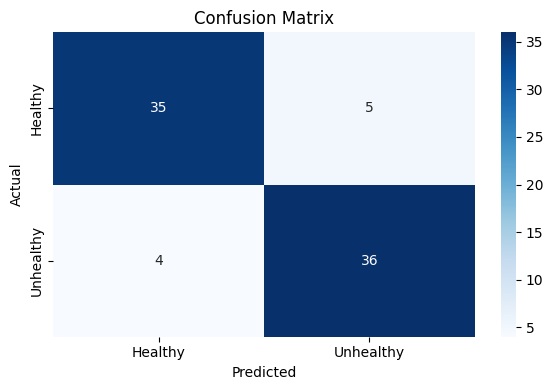

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# XGBoost


## Training

In [ ]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1': f1_score(y_test, y_pred, average='weighted'),
    'Balanced Accuracy' : balanced_accuracy_score(y_test, y_pred),
}

for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

metrics_dict['XGBoost'] =  metrics

Accuracy: 0.8250
Precision: 0.8385
Recall: 0.8250
F1: 0.8232
Balanced Accuracy: 0.8250


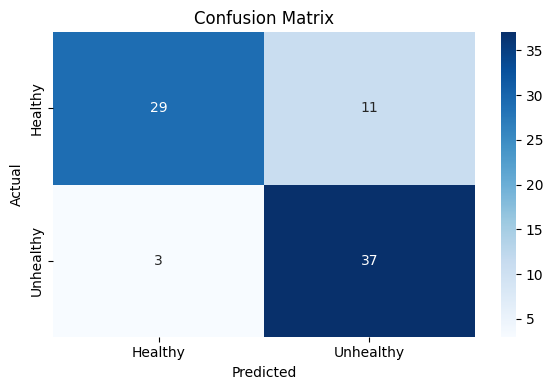

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# LightGBM


## Training

In [ ]:
model = LGBMClassifier(random_state=42, verbosity = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1': f1_score(y_test, y_pred, average='weighted'),
    'Balanced Accuracy' : balanced_accuracy_score(y_test, y_pred),
}

for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

metrics_dict['LGBM'] =  metrics

Accuracy: 0.8000
Precision: 0.8069
Recall: 0.8000
F1: 0.7989
Balanced Accuracy: 0.8000


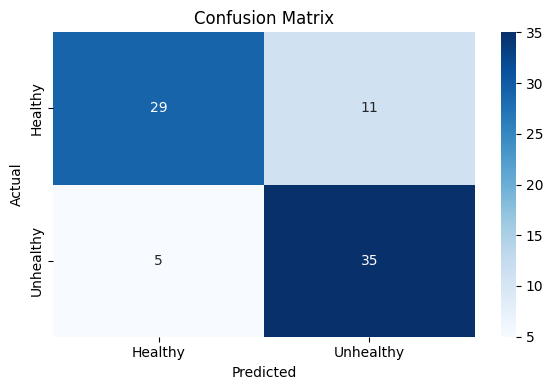

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Metrics

In [ ]:
data = []
for model, metrics in metrics_dict.items():
    for metric, value in metrics.items():
        data.append({'Model': model, 'Metric': metric, 'Value': value})
metric_df = pd.DataFrame(data)

def plot_metric(metric_name):

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        x='Model',
        y='Value',
        data=metric_df[metric_df['Metric'] == metric_name],
        palette=sns.color_palette("Set2"),
        saturation=0.8
    )

    ax.set_title(metric_name + "\n", fontsize=14)
    ax.set_ylim(0, pd.to_numeric(metric_df[metric_df['Metric'] == metric_name].select_dtypes(include=[np.number]).max(), errors='coerce').max() + 0.1)

    ax.set_xlabel('')
    ax.set_ylabel('Score', fontsize=12)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'Balanced Accuracy']

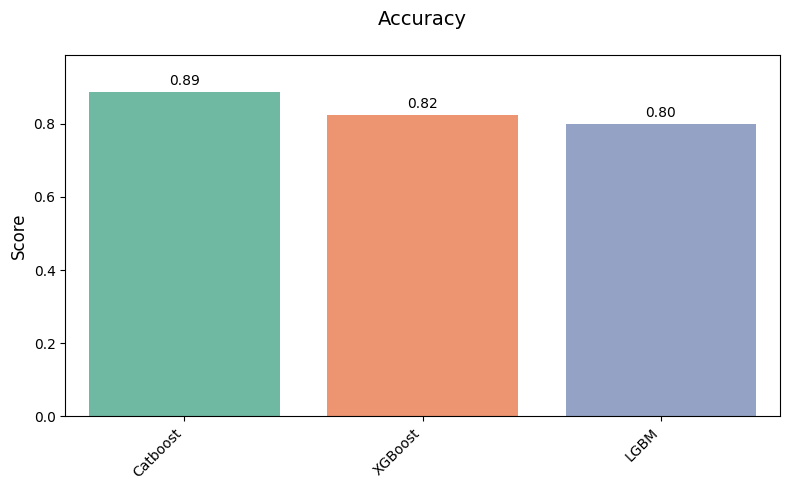

In [ ]:
plot_metric(metric_names[0])

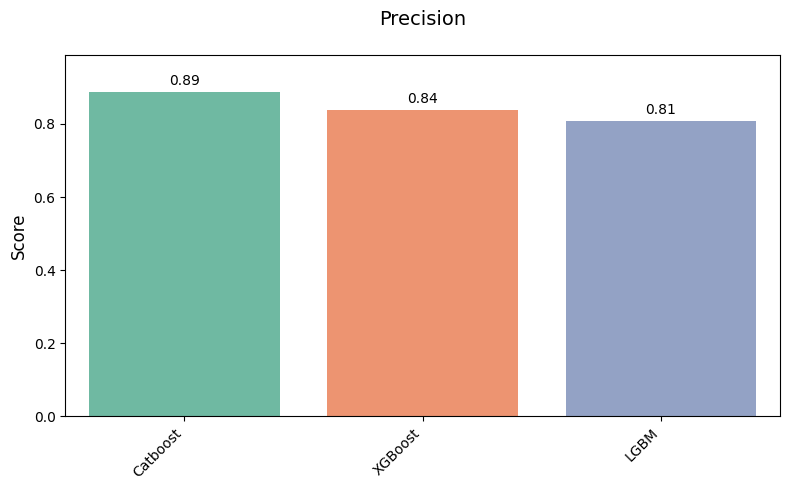

In [ ]:
plot_metric(metric_names[1])

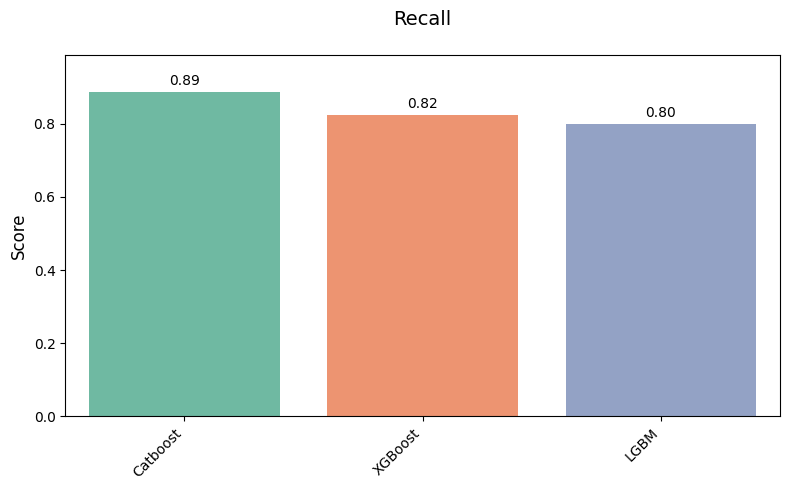

In [ ]:
plot_metric(metric_names[2])

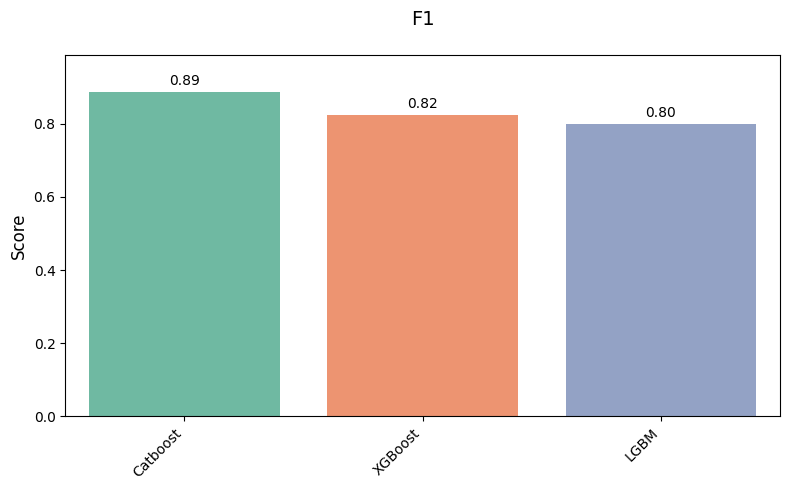

In [ ]:
plot_metric(metric_names[3])

In [ ]:
metric_df.pivot(index="Model", columns="Metric", values="Value").sort_values(by = 'Accuracy', ascending = False).reset_index()

Metric,Model,Accuracy,Balanced Accuracy,F1,Precision,Recall
0,Catboost,0.8875,0.8875,0.887482,0.887742,0.8875
1,XGBoost,0.8250,0.8250,0.823232,0.838542,0.8250
2,LGBM,0.8000,0.8000,0.798869,0.806905,0.8000
